The following Jupyter notebook is meant to provide a quick way to calculate and plot the light curves of a set of photometric measurements. 
Simply run each cell in order to obtain the plots. 

A couple of things to keep in mind:
1. The Excell file should be saved in the same folder as the .ipynb code. 
2. The file should be in excel format, ie. xls, xlsx, xlsm,etc. Or .csv. The first cell asks you input the file name with extension to submit click enter. 
3. It is assumed that the Data is found on the first spreadsheet, and that the first row contains the header (ie. the name of each column.) 
If the header is not the first row in the column adjust header = 0 accordingly. Failing to update this will result in NAN values. 
4. The first object must be the targeted star. 
5. To propagate the error we are using the Error(T) values. 

In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Legend,Whisker
#from sys import exit
from bokeh.palettes import Category20,Category20b,Category20c

#User Input. Enter the name of the file
#file_name = str(input('file name with extension:(Press enter to submit) '))
file_name = "wasp.xlsx"

#Determine if the file is in csv or excel format. 
if file_name.endswith('.csv'):
    try:
        data = pd.read_csv(file_name,header=0)
    except:
        print("ERROR. Please run again and enter a valid file name")
        raise ValueError()
        #exit()
else:
    try:
        data = pd.read_excel(file_name, sheet_name=0,header=0)
    except:
        print("ERROR.Please run again and enter a valid file name")
        raise ValueError
        #exit()
# delete white space in front of column names. 
data.columns = data.columns.str.replace(' ', '')
data.columns = data.columns.str.strip() 
idata = pd.DataFrame(data, columns=['Index','Image','Mag','Error(T)','JD']) # Use only required columns 

#Check number of objects measured. 
i_0=int((min(idata['Index'])))  
i_n=int((max(idata['Index'])))
#drop rows with empty values
idata.dropna()
#Get list of image names as per Mira.
image_names = (idata.Image.unique())   
print(f"There are: {len(image_names)} data points for {i_n} stars")

#Function to get differential photometry. 
def magnitude_difference(ref,data=idata):
    length = list(data.Index.unique())
    i_n=len(length)
    mag_diff=[]
    for i in length:
        #print(i)
        x = np.array(data[data['Index']==i]['Mag'])
        xx = np.array(data[data['Index']==i]['Image'])
        y = (np.array(data[data['Index']==ref]['Mag']))
        yy = np.array(data[data['Index']==ref]['Image'])
        mag_diff.append(x-y)
        for k in range(len(xx)):
            if xx[k]==yy[k]:
                pass
            else:
                print('ERROR')
    return mag_diff

# Function to propagate the errors. 
def error_prop(ref,data=idata,):
    length = list(data.Index.unique())
    i_n=len(length)
    error=[]
    for i in length:
        e_x = np.array(data[data['Index']==i]['Error(T)'])
        e_y =np.array(data[data['Index']==ref]['Error(T)'])
        error.append(np.sqrt(e_x**2+e_y**2))
    return error

#Function to delete data points. Ie. Delete one image from data set. 
def delete_data_points(data,names=image_names):
    print('Please enter one by one the data points you want to omit separated by a comma.')
    print('example: to omit first and second data points enter: 1,2')
    print('To use all data leave empty and click enter.')
    # input comma separated elements as string 
    string = str (input("Enter comma separated integers (Click Enter to submit): "))
    #print ("Input string: ", string)

    # convert to the list
    input_list = string.split (",")

    # convert each element as integers
    li = []
    try:
        for i in input_list:
            li.append(int(i))
        if len(li)>0 and type(li[0])==int:
            for i in(li):

                ind = data[((data.Image == names[i-1]))].index
                data = data.drop(ind)
    except:
            print('NO DATA POINTS OMITED')

    return data

#Function to delete a star from the analysis. Ie. Exclude a star from subtraction and average
def delete_star(data):
    print('Please enter one by one the stars you want to omit separated by a comma.')
    print('To use all stars leave empty and click enter.')
    #input comma separated elements as string 
    string = str (input("Enter comma separated integers: "))
    # conver to the list
    input_list = string.split (",")
    # convert each element as integers
    li = []
    try:
        for i in input_list:
            li.append(int(i))
        if len(li)>0 and type(li[0])==int:
            for i in(li):
                ind = data[((data.Index == i))].index
                data = data.drop(ind)
    except:
            print('NO STARS OMITED')
    return data

#Function to calculate average magnitude difference and propagate error. 
def average_cal(ref,mag,errors,data):
    mags =  mag.copy()
    errorss = errors.copy()
    length = list(data.Index.unique())
    ind = length.index(ref)
    i_n=len(length)
    del(mags[ind])
    del(errorss[ind])
    average = []
    error_average = []
    for i in range(len(mags[0])):
        avg=0
        avg_err=0
        for j in range(len(mags)):
            avg = avg+mags[j][i]
            avg_err = avg_err + errorss[j][i]**2
        average.append(avg/len(mags))
        error_average.append(np.sqrt(avg_err)/len(mags))
        
            
    return average,error_average
    
# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()


There are: 15 data points for 23 stars


Loading BokehJS ...

Plot the differential photometry light curve. Use the tool bar to adjust the view of the graph and then save. 
Note that the errors were calculated but not plotted in this figure. 
The light curve is calculated by subtracting the measured instrumental magnitude of the suspected exoplanet host star minus the magnitude of each of the reference stars. 

$error = \sqrt{err(y_i)^2+err(y_j^2)}$


In [21]:
#Check to see wether we want to delete any data. 
clean_data = delete_data_points(idata)
clean_data_2 = delete_star(clean_data)

#Get input on star we will compare. Ie. Suspected exoplanet host or reference star. 
is_valid = False
while (is_valid != True):
    ref=(input('Object for which to do differential photometry:'))
    try:
        star = int(ref)
        is_valid = True
    except:
        print('ERROR. Enter single integer')

#Calculate the magnitude difference for sleceted star. 
mag_diff = magnitude_difference(int(star),data=clean_data_2)

#Propagate the error- 
err = error_prop(int(star),data=clean_data_2)
#Get the Julian Dates of the observation- 
julian_date = np.array(clean_data_2[clean_data_2['Index']==int(star)]['JD'])
#Check to see if any star was omitted from analysis. 
indeces=list(clean_data_2.Index.unique())

# We subtract the mean JD to make our plot more readable. 
xs = julian_date - np.mean(julian_date)
#Initiate the figure
p = figure(
    title="Differential Photometry Light Curve",
   x_axis_label=f"Julian Date + {np.mean(julian_date)}", y_axis_label='Instrumental Magnitude Difference',width=900)

#Plotting
colours = Category20[20]+Category20b[20]+Category20c[20]
for j in range(len(mag_diff)):
    p.line(xs,mag_diff[j],legend=f"Object {indeces[j]}",color = colours[j])
    p.circle(xs,mag_diff[j],legend=f"Object {indeces[j]}",fill_color = colours[j],line_color=colours[j],size=3)
    err_xs = []
    err_ys = []
    # create the coordinates for the errorbars
    for x, y, yerr in zip(xs, mag_diff[j], err[j]):
        err_xs.append((x, x))
        err_ys.append((y - yerr, y+ yerr))

    # plot them
    p.multi_line(err_xs, err_ys, color=colours[j])





show(p)

Please enter one by one the data points you want to omit separated by a comma.
example: to omit first and second data points enter: 1,2
To use all data leave empty and click enter.
NO DATA POINTS OMITED
Please enter one by one the stars you want to omit separated by a comma.
To use all stars leave empty and click enter.
NO STARS OMITED


# Calculate and plot the average difference between the target star and the reference objects. 

$ error = \frac{\sqrt{\sum{err(y_i)}^2}}{N} $


In [22]:
#Calculate Average magnitude difference. 
average, average_err = average_cal(int(star),mag_diff,err,clean_data_2)
#Initiate the second figure.
p_1 = figure(
    title="Average Magnitude Differences",
   x_axis_label=f"Julian Date + {np.mean(julian_date)}", y_axis_label='Instrumental Magnitude Difference',width=900)
#plot the second figure. 
p_1.line(xs,average,color = 'blue')
p_1.circle(xs,average,fill_color ='blue',line_color='blue',size=3)

err_xs = []
err_ys = []
# create the coordinates for the errorbars
for x, y, yerr in zip(xs, average, average_err):
    err_xs.append((x, x))
    err_ys.append((y - yerr, y+ yerr))

    # plot them
p_1.multi_line(err_xs, err_ys, color='red')
show(p_1)


If for some reason you are having trouble with the interactive plots; below is the same average magnitude difference plot but using pyplot, a simpler graphing library. 
Note that the image from this file will be saved to the folder containing the notebook. 

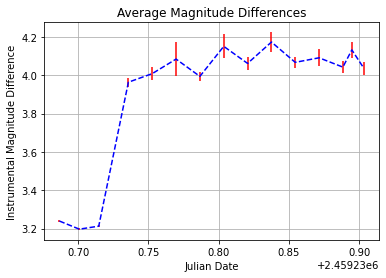

In [19]:
average, average_err = average_cal(int(star),mag_diff,err,clean_data_2)
plt.plot(julian_date,average,'--',color='b')
plt.errorbar(julian_date,average,yerr=average_err,fmt='none',ecolor='r')
plt.title('Average Magnitude Differences')
plt.xlabel('Julian Date')
plt.ylabel('Instrumental Magnitude Difference')
plt.grid(which='both', axis='both')
plt.savefig('average_mag.pdf')


You may want to get the results of the calculatuions and check them in excel, or use a different plotting tool. 
The cell below will save a .csv file in the folder containing the notebook. Each column will be the result of doing the subtraction between our reference object and the target exoplanet star. ie. magnitude difference for object_i contains the subtraction of the measured magnitudes for every time step. 

In [6]:
#Start new array to create the pandas data frame with the results. 
output_array = {}
for i in range(len(mag_diff)):
    output_array[f"Magnitude difference for object{i}"]=mag_diff[i]
    output_array[f"error{i}"]=err[i]
output_array["average"]=average
output_array["error_av"]=average_err

output_file = pd.DataFrame(output_array)
output_file.to_csv('results.csv')